In [218]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from astropy.io import fits
import os
from matplotlib.colors import LogNorm


matplotlib.rcParams['figure.figsize'] = (12, 10)

In [219]:
# Global variables
HOME_DIR = os.environ['HOME']
FITS_DIR = os.path.join(HOME_DIR, '.birales/visualisation/fits/')
TRACK_DIR =  os.path.join(HOME_DIR, '.birales/debug/detection/')

FITS_FILENAME = 'Observation_2018-03-22T0934/Observation_2018-03-22T0934_filtered.fits'
TRACK_FILENAME = '20180322/BIRALES_OUT_20170630_001.csv'

SENSITIVITY_THOLD = 75
BEAM_ID = 11

In [220]:
filtered_fits_filepath = os.path.join(FITS_DIR, FITS_FILENAME)
filtered_data = fits.getdata(filtered_fits_filepath)
print ('Filtered image shape:', filtered_data.shape)

track_filepath = os.path.join(TRACK_DIR, TRACK_FILENAME)
track_df = pd.read_csv(track_filepath)
if BEAM_ID:
    track_df = track_df[track_df['beam_id'] == BEAM_ID]
    
print(track_df.shape[0], 'detections in track for beam', BEAM_ID)

Filtered image shape: (1, 8192, 288)
24 detections in track for beam 11


In [221]:
min_channel, max_channel = track_df['channel_sample'].min(), track_df['channel_sample'].max()
min_time, max_time = track_df['time_sample'].min(), track_df['time_sample'].max()

# Padding in pixels
c_padding = 50
t_padding = 50

print(min_channel, max_channel, min_time, max_time)
print('Padding is', c_padding, t_padding)

reduced_filtered_data = filtered_data[0, min_channel-c_padding:max_channel+c_padding, min_time-t_padding:max_time+t_padding]
reduced_filtered_data = np.abs(reduced_filtered_data)
min_power = track_df['snr'].min()
max_power = track_df['snr'].max()
log_norm = LogNorm(vmin=min_power, vmax=max_power)

print(min_power, max_power)

438 466 161 183
Padding is 50 50
22.8050054271 28.2843989924


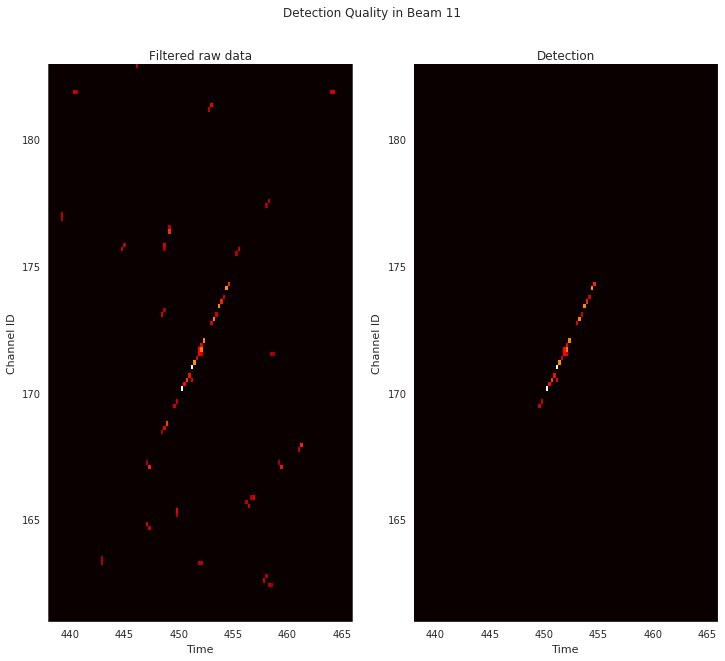

In [238]:
# Show the reduced filtered data
fig, (ax_filtered, ax_result) = plt.subplots(1,2)
if BEAM_ID:
    fig.suptitle('Detection Quality in Beam '+str(BEAM_ID))
else:
    fig.suptitle('Detection Quality Accross all beams')

# Plot the de-noised raw data    
im_filtered = ax_filtered.imshow(reduced_filtered_data, aspect='auto',  
                                 interpolation='none', cmap=plt.cm.hot, extent=[min_channel,max_channel,min_time,max_time])
ax_filtered.set(xlabel='Time', ylabel='Channel ID', title='Filtered raw data')
ax_filtered.grid(False)

# Plot the detection data
result_data = np.zeros(filtered_data.shape)[0, :,:]

for index, row in track_df.iterrows():
    result_data[row['channel_sample'], row['time_sample']] = filtered_data[0, row['channel_sample'], row['time_sample']]

result_data = result_data[min_channel-c_padding:max_channel+c_padding, min_time-t_padding:max_time+t_padding]

ax_result.imshow(result_data,cmap=plt.cm.hot,aspect='auto', 
                 interpolation='none',  extent=[min_channel,max_channel,min_time,max_time])
ax_result.grid(False)
ax_result.set(xlabel='Time', ylabel='Channel ID',  title='Detection')


In [240]:
expected = filtered_data[filtered_data > SENSITIVITY_THOLD].shape[0]

actual = track_df.shape[0]

print ('Expected:',expected,'Actual', actual, 'Detection Score:', np.round(actual/expected * 100,2),'%')

Expected: 458 Actual 24 Detection Score: 5.24 %
